In [1]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nbformat

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,Dropout,Conv2D
from keras.layers import LSTM
from keras.layers import Reshape
from sklearn.model_selection import train_test_split
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

2023-07-30 20:22:42.136241: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-30 20:22:42.156760: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%run 'one_hot.ipynb'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        print("GPU device:", gpu)
        print("number of GPU device: ",len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU devices found.")


tf.config.experimental.set_memory_growth(gpus[0], True)



GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
number of GPU device:  1


2023-07-30 20:22:44.073931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 20:22:44.086031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 20:22:44.086116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
fasta_file = os.path.join('..','repertoire','shm','shm_default.fasta')
annotation_file = os.path.join('..','repertoire','shm','shm_default.tsv')

In [5]:
# pad the sequence and get the input
def process_input(sequences,chunk_size):
    """
    To ensure every sequence has the same length, I pad the sequence with "N" up to the length of set chunk_size
    Then encode every sequence to get the final input for the model
    input: a list of raw sequences and chunk size
    output: the input of model (X)
    """
    padded_seq = []
    pad = ''
    for seq in sequences:
        pad = seq.ljust(chunk_size, 'N')
        padded_seq.append(pad)
    
    combined_sequence = ''.join(padded_seq)
    one_hot_sequences = one_hot_encode(combined_sequence) 
   
    return one_hot_sequences

In [6]:
chunk_size=450
sequences = input_file(fasta_file)
X = process_input(sequences,chunk_size)
X.shape

/tmp/ipykernel_405649/3505619144.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


(4500000, 5)

In [7]:
df = pd.read_csv(annotation_file, sep='\t', header=0)
chunk_size=450
VDJ_seq = []
VDJ_num = []
for i in range(len(df)):
    seq = translate_output(df,i)
    seq_num = output_catogory(seq)
    VDJ_seq.append(seq)
    VDJ_num.append(seq_num)
        
combined_vdj = ''.join(VDJ_seq)
encoded_vdj = output_encoding(combined_vdj)

/tmp/ipykernel_405649/2970507474.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(seq, np.int8)
/tmp/ipykernel_405649/3818073805.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


In [8]:
print(len(combined_vdj))
print(encoded_vdj.shape)
y = encoded_vdj

4500000
(4500000, 5)


In [9]:
train_data_ratio = 0.8 # Choose 80% of the data for training
data_len = len(X)
train_data_len = int(data_len*train_data_ratio)
train_x = X[:train_data_len]
train_y = y[:train_data_len]
test_x = X[train_data_len:]
test_y = y[train_data_len:]

In [10]:
timesteps = 450  

train_x_tensor = np.array([train_x[i:i+timesteps] for i in range(0, train_x.shape[0]-timesteps+1, timesteps)])
train_y_tensor = np.array([train_y[i:i+timesteps] for i in range(0, train_y.shape[0]-timesteps+1, timesteps)])
test_x_tensor = np.array([test_x[i:i+timesteps] for i in range(0, test_x.shape[0]-timesteps+1, timesteps)])
test_y_tensor = np.array([test_y[i:i+timesteps] for i in range(0, test_y.shape[0]-timesteps+1, timesteps)])


In [11]:
EPCOHS = 100 #  an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation.
BATCH_SIZE = 450 # a set of N samples. The samples in a batch are processed` independently, in parallel. If training, a batch results in only one update to the model.
INPUT_DIM = 4 # a vocabulary of 4 words in case of fnn sequence (ATCG)
OUTPUT_DIM = 50 # Embedding output
RNN_HIDDEN_DIM = 62
DROPOUT_RATIO = 0.2 # proportion of neurones not used for training
MAXLEN = 150 # cuts text after number of these characters in pad_sequences

In [16]:
from keras.layers import Dense, Dropout, LSTM, Embedding, Activation, Lambda, Bidirectional
from tensorflow.keras.layers import TimeDistributed
import time

In [17]:
model = Sequential()

model.add(Bidirectional(LSTM(units=RNN_HIDDEN_DIM, return_sequences=True),input_shape=(450,5)))
model.add(Dropout(DROPOUT_RATIO))
model.add(Bidirectional(LSTM(units=RNN_HIDDEN_DIM, return_sequences=True)))

model.add(TimeDistributed(Dense(5, activation='softmax')))
model.add(Dropout(DROPOUT_RATIO))
model.add(Dense(5, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

start_time = time.time()
log_dir = "logs/LSTMshm/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tf_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
model.fit(train_x_tensor, train_y_tensor, validation_data = (test_x_tensor, test_y_tensor), epochs=150, batch_size=64, callbacks=[tf_callback])
end_time = time.time()
training_time = end_time - start_time
print("Training the model took {:.2f} seconds".format(training_time))

2023-07-30 20:24:52.239031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-30 20:24:52.239604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-30 20:24:52.240010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 450, 124)         33728     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 450, 124)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 450, 124)         92752     
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 450, 5)           625       
 tributed)                                                       
                                                                 
 dropout_7 (Dropout)         (None, 450, 5)            0         
                                                      

2023-07-30 20:24:52.452338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-30 20:24:52.452869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-30 20:24:52.453271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/125 [==============================] - ETA: 0s - loss: 1.1687 - accuracy: 0.7923

2023-07-30 20:25:01.014161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-30 20:25:01.014851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-30 20:25:01.015366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/125 [==============================] - 10s 60ms/step - loss: 1.1687 - accuracy: 0.7923 - val_loss: 1.0260 - val_accuracy: 0.8368
Epoch 2/150
125/125 [==============================] - 7s 56ms/step - loss: 0.9898 - accuracy: 0.8284 - val_loss: 0.8910 - val_accuracy: 0.8368
Epoch 3/150
125/125 [==============================] - 7s 56ms/step - loss: 0.8939 - accuracy: 0.8284 - val_loss: 0.8048 - val_accuracy: 0.8368
Epoch 4/150
125/125 [==============================] - 7s 56ms/step - loss: 0.7745 - accuracy: 0.8521 - val_loss: 0.6439 - val_accuracy: 0.9371
Epoch 5/150
125/125 [==============================] - 7s 56ms/step - loss: 0.7976 - accuracy: 0.7740 - val_loss: 0.6914 - val_accuracy: 0.8360
Epoch 6/150
125/125 [==============================] - 7s 56ms/step - loss: 0.7159 - accuracy: 0.7986 - val_loss: 0.6058 - val_accuracy: 0.8368
Epoch 7/150
125/125 [==============================] - 7s 56ms/step - loss: 0.6044 - accuracy: 0.8180 - val_loss: 0.4707 - val_accuracy: 0.8368
Epo

In [19]:
y_pred = model.predict(test_x_tensor)
print(y_pred.shape)
print(test_y_tensor.shape)

2023-07-30 20:42:31.843583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-30 20:42:31.844427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-30 20:42:31.844940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/63 [..............................] - ETA: 28s

2023-07-30 20:42:32.062578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-30 20:42:32.083405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-30 20:42:32.083952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

63/63 [==============================] - 2s 22ms/step
(2000, 450, 5)
(2000, 450, 5)


In [22]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

([<matplotlib.axis.YTick at 0x7f4520164f50>,
 [Text(0, 0.5, 'V'),
  Text(0, 1.5, 'D'),
  Text(0, 2.5, 'J'),
  Text(0, 3.5, 'N'),
  Text(0, 4.5, 'X')])

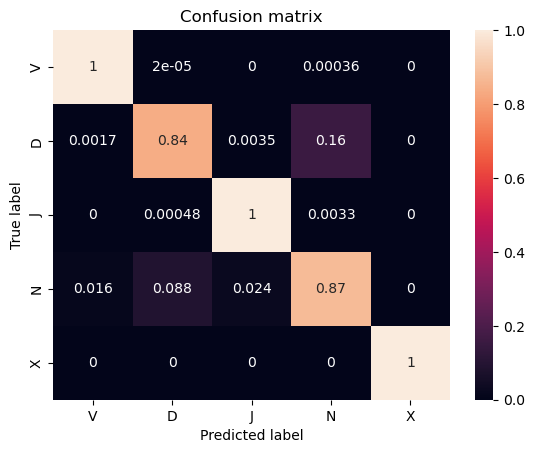

In [23]:
pred_classes = np.argmax(y_pred, axis=-1)
y_true = np.argmax(test_y_tensor,axis=-1)
y_true_flat = y_true.flatten()
y_pred_flat = pred_classes.flatten()
cm = confusion_matrix(y_true_flat,y_pred_flat)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=['V', 'D', 'J', 'N','X'])
labels = ['V', 'D', 'J', 'N','X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

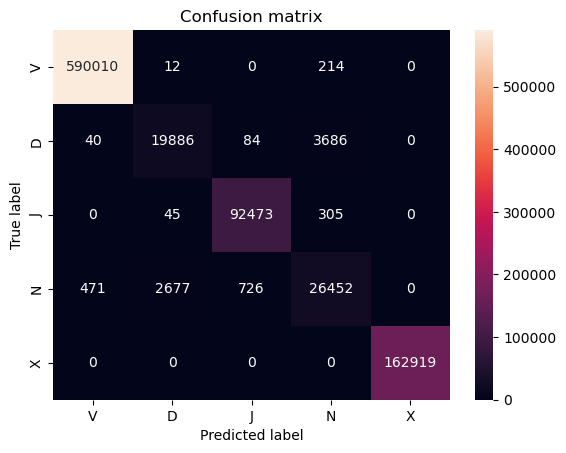

In [24]:
plt.figure()
sns.heatmap(cm, annot=True, fmt="d")

labels = ['V', 'D', 'J', 'N','X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

In [26]:
# accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print('Accuracy:', accuracy)

# precision
precision = precision_score(y_true_flat, y_pred_flat, average='macro')
print('Precision:', precision)

# recall
recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print('Recall:', recall)

# F1-score
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print('F1 Score:', f1)

Accuracy: 0.9908222222222223
Precision: 0.9464844234217658
Recall: 0.941462937059742
F1 Score: 0.9438746013631443


## SHM set

In [44]:
fasta_file = os.path.join('..','repertoire','shm','shm_default_2000.fasta')
annotation_file = os.path.join('..','repertoire','shm','shm_default_2000.tsv')

In [45]:
sequences = input_file(fasta_file)
X_shm = process_input(sequences,chunk_size)
X_shm.shape

/tmp/ipykernel_405649/3505619144.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


(900000, 5)

In [46]:
df = pd.read_csv(annotation_file, sep='\t', header=0)
chunk_size=450
VDJ_seq = []
VDJ_num = []
for i in range(len(df)):
    seq = translate_output(df,i)
    seq_num = output_catogory(seq)
    VDJ_seq.append(seq)
    VDJ_num.append(seq_num)
        
combined_vdj = ''.join(VDJ_seq)
encoded_vdj = output_encoding(combined_vdj)

/tmp/ipykernel_405649/2970507474.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(seq, np.int8)
/tmp/ipykernel_405649/3818073805.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


In [47]:
print(len(combined_vdj))
print(encoded_vdj.shape)
y_shm = encoded_vdj

900000
(900000, 5)


In [48]:
timesteps = 450  

X_shm_tensor = np.array([X_shm[i:i+timesteps] for i in range(0, X_shm.shape[0]-timesteps+1, timesteps)])
y_shm_tensor = np.array([y_shm[i:i+timesteps] for i in range(0, y_shm.shape[0]-timesteps+1, timesteps)])


In [49]:
y_pred = model.predict(X_shm_tensor)
print(y_pred.shape)
print(y_shm_tensor.shape)

63/63 [==============================] - 1s 13ms/step
(2000, 450, 5)
(2000, 450, 5)


([<matplotlib.axis.YTick at 0x7f467c71ac10>,
 [Text(0, 0.5, 'V'),
  Text(0, 1.5, 'D'),
  Text(0, 2.5, 'J'),
  Text(0, 3.5, 'N'),
  Text(0, 4.5, 'X')])

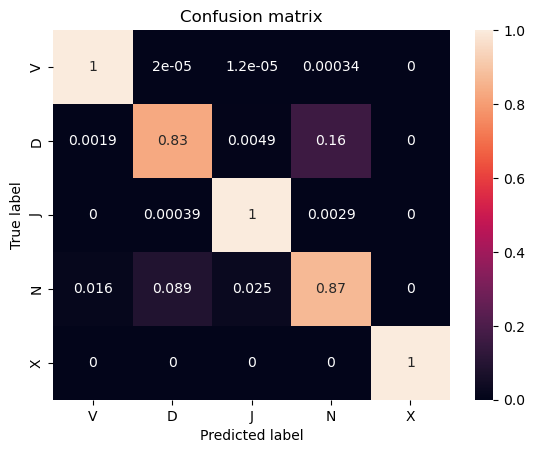

In [50]:
pred_classes = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_shm_tensor,axis=-1)
y_true_flat = y_true.flatten()
y_pred_flat = pred_classes.flatten()
cm = confusion_matrix(y_true_flat,y_pred_flat)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=['V', 'D', 'J', 'N','X'])
labels = ['V', 'D', 'J', 'N','X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

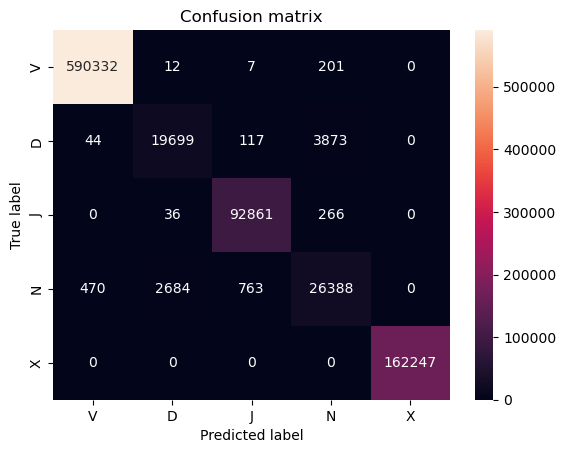

In [51]:
plt.figure()
sns.heatmap(cm, annot=True, fmt="d")

labels = ['V', 'D', 'J', 'N','X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [52]:
# accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print('Accuracy:', accuracy)

# precision
precision = precision_score(y_true_flat, y_pred_flat, average='macro')
print('Precision:', precision)

# recall
recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print('Recall:', recall)

# F1-score
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print('F1 Score:', f1)

Accuracy: 0.9905855555555556
Precision: 0.9453267072099854
Recall: 0.9394317881898789
F1 Score: 0.9422330991807725


## non shm set

In [53]:
fasta_file = os.path.join('..','repertoire','test','test_2000.fasta')
annotation_file = os.path.join('..','repertoire','test','test_2000.tsv')

In [54]:
sequences = input_file(fasta_file)
X_nonshm = process_input(sequences,chunk_size)
X_nonshm.shape

/tmp/ipykernel_405649/3505619144.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


(900000, 5)

In [55]:
df = pd.read_csv(annotation_file, sep='\t', header=0)
chunk_size=450
VDJ_seq = []
VDJ_num = []
for i in range(len(df)):
    seq = translate_output(df,i)
    seq_num = output_catogory(seq)
    VDJ_seq.append(seq)
    VDJ_num.append(seq_num)
        
combined_vdj = ''.join(VDJ_seq)
encoded_vdj = output_encoding(combined_vdj)
print(len(combined_vdj))
print(encoded_vdj.shape)
y_nonshm = encoded_vdj
timesteps = 450  

X_nonshm_tensor = np.array([X_nonshm[i:i+timesteps] for i in range(0, X_nonshm.shape[0]-timesteps+1, timesteps)])
y_nonshm_tensor = np.array([y_nonshm[i:i+timesteps] for i in range(0, y_nonshm.shape[0]-timesteps+1, timesteps)])
y_pred = model.predict(X_nonshm_tensor)
print(y_pred.shape)
print(y_nonshm_tensor.shape)

900000
(900000, 5)
 5/63 [=>............................] - ETA: 0s

/tmp/ipykernel_405649/2970507474.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(seq, np.int8)
/tmp/ipykernel_405649/3818073805.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


63/63 [==============================] - 1s 13ms/step
(2000, 450, 5)
(2000, 450, 5)


([<matplotlib.axis.YTick at 0x7f4642945090>,
 [Text(0, 0.5, 'V'),
  Text(0, 1.5, 'D'),
  Text(0, 2.5, 'J'),
  Text(0, 3.5, 'N'),
  Text(0, 4.5, 'X')])

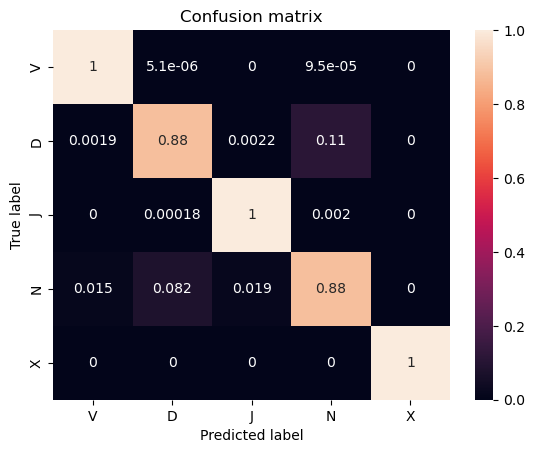

In [56]:
pred_classes = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_nonshm_tensor,axis=-1)
y_true_flat = y_true.flatten()
y_pred_flat = pred_classes.flatten()
cm = confusion_matrix(y_true_flat,y_pred_flat)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=['V', 'D', 'J', 'N','X'])
labels = ['V', 'D', 'J', 'N','X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

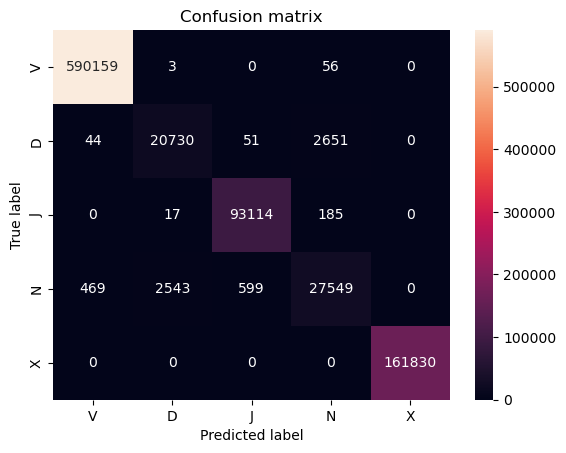

In [57]:
plt.figure()
sns.heatmap(cm, annot=True, fmt="d")

labels = ['V', 'D', 'J', 'N','X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [58]:
# accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print('Accuracy:', accuracy)

# precision
precision = precision_score(y_true_flat, y_pred_flat, average='macro')
print('Precision:', precision)

# recall
recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print('Recall:', recall)

# F1-score
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print('F1 Score:', f1)

Accuracy: 0.9926466666666667
Precision: 0.9574325386273712
Recall: 0.9529758150315206
F1 Score: 0.9551759174693624
